# Load Data

In [1]:
hyperparameters = {'hidden_dim': 128, 'batch_size': 128, 'n1_gat_layers': 1, 'n2_gru_layers': 1, 'num_heads': 4, 'dropout': 0.04033931265087129, 'learning_rate': 0.00015574186652855083, 'pos_lambda': 0.5756532880616873, 'bios_hidden_dim': 32, 'pres_hidden_dim': 64, 'k': 5, 'num_clusters': 240}

In [2]:
import preprocess
import imp
imp.reload(preprocess)

data = preprocess.preprocess_pipeline(num_clusters=hyperparameters['num_clusters'])

2025-09-10 14:45:49.933306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757504749.946934 1417543 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757504749.951076 1417543 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757504749.962670 1417543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757504749.962690 1417543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757504749.962693 1417543 computation_placer.cc:177] computation placer alr

1. Include only first admissions: N=32513
2. Exclusion by ages: N=25548
3. Include only patients who admitted for at least 24 hours: N=25168
4. Exclude patients who died within 54-hours of admission: N=24556


/home/bnet/kupershmidt/HML/preprocess.py:246: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pivot = pd.pivot_table(merged, index=['subject_id', 'hadm_id', pd.Grouper(key='charttime', freq=PREDICT_FREQ)],
/home/bnet/kupershmidt/HML/preprocess.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)
/home/bnet/kupershmidt/HML/preprocess.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=

Pooled embeddings shape: 24529
Number of subjects: 24529


# Datasets creation

In [3]:
data["prescriptions_train"].shape[0] == data["padded_tensor_train"].shape[0]

True

In [15]:
import Dataset
import imp
imp.reload(Dataset)
import torch
from torch.utils.data import DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k = hyperparameters['k']

train_labels = torch.tensor(data["y_train"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
val_labels = torch.tensor(data["y_val"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
test_labels = torch.tensor(data["y_test"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)


batch_size = hyperparameters['batch_size']
datasets = {x: Dataset.PatientDataset(d, y, core=data["padded_tensor_core"], padding_mask=m, padding_mask_core=data["padding_mask_core"], k=k ,notes=n, bios=b, prescriptions=p) for x, d, y, m, n, b, p in
        zip(['train', 'val', 'test'], [data["padded_tensor_train"], data["padded_tensor_val"], data["padded_tensor_test"]],
            [train_labels, val_labels, test_labels],
            [data["padding_mask_train"], data["padding_mask_val"], data["padding_mask_test"]],
            [data["notes_df_train"].embeddings.values.tolist(),
             data["notes_df_val"].embeddings.values.tolist(),
             data["notes_df_test"].embeddings.values.tolist()],
             [torch.tensor(data["bio_train"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_val"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_test"].values >= 1, dtype=torch.float32).to(DEVICE)],
              [torch.tensor(data["prescriptions_train"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_val"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_test"].values, dtype=torch.float32).to(DEVICE)])}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

/home/bnet/kupershmidt/HML/Dataset.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bios = torch.tensor(bios,dtype=torch.float32)
/home/bnet/kupershmidt/HML/Dataset.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prescriptions =  torch.tensor(prescriptions,dtype=torch.float32)


# Model Training

In [116]:
import Model 
import imp
imp.reload(Model)
model = Model.GraphGRUMortalityModel(input_dim=data["padded_tensor_train"].shape[2], hidden_dim=hyperparameters['hidden_dim'], 
                                     n1_gat_layers=1, n2_gru_layers=1, 
                                     X_core=data["padded_tensor_core"], num_of_bios=data["bio_train"].shape[1],
                                     num_prescriptions=data["prescriptions_train"].shape[-1], 
                                     bios_hidden_dim=hyperparameters['bios_hidden_dim'], pres_hidden_dim=hyperparameters['pres_hidden_dim'], 
                                     core_padding_mask=data["padding_mask_core"], num_heads=hyperparameters['num_heads'], 
                                     dropout=hyperparameters['dropout'], seq_len=data["padded_tensor_train"].shape[1], k=k, gnn_flag=True).to(DEVICE)
torch.manual_seed(1234)
model.train_all(dataloaders, datasets, epochs=10, learning_rate=hyperparameters['learning_rate'], pos_lambda=hyperparameters['pos_lambda'])
print("Training completed. Validating on test set...")

model.validate(dataloaders['test'], datasets['test'])


/home/bnet/kupershmidt/anaconda3/envs/spider/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04033931265087129 and num_layers=1
  warnings.warn(
/home/bnet/kupershmidt/anaconda3/envs/spider/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Pos weight 0: 7.5538
Pos weight 1: 1.1253
Pos weight 2: 23.8500
Starting epoch 1/10
100%|██████████| 152/152 [01:39<00:00,  1.53it/s]
Epoch 1/10, Loss: 2.3130
100%|██████████| 20/20 [00:12<00:00,  1.61it/s]
Val Mortality - AUC: 0.7886 | AP: 0.3381
Val Prolonged LOS - AUC: 0.7366 | AP: 0.7184
Val Readmission - AUC: 0.6431 | AP: 0.0844
Best model updated
Starting epoch 2/10
100%|██████████| 152/152 [01:37<00:00,  1.56it/s]
Epoch 2/10, Loss: 2.1684
100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
Val Mortality - AUC: 0.8139 | AP: 0.3765
Val Prolonged LOS - AUC: 0.7635 | AP: 0.7449
Val Readmission - AUC: 0.6382 | AP: 0.0661
Best model updated
Starting epoch 3/10
100%|██████████| 152/152 [01:37<00:00,  1.55it/s]
Epoch 3/10, Loss: 2.1128
100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
Val Mortality - AUC: 0.8269 | AP: 0.3918
Val Prolonged LOS - AUC: 0.7735 | AP: 0.7514
Val Readmission - AUC: 0.6440 | AP: 0.0701
Best model updated
Starting epoch 4/10
100%|██████████| 152/152 [01:37<00:00,  1.5

(0.8661206932607515,
 0.5180461697851331,
 0.8093948080798675,
 0.783683030037214,
 0.6313058137724186,
 0.07783062835753989)

In [129]:
model.initialize_calibrator(datasets['val'].y,model.validate(dataloaders['val'], datasets['val'], return_predictions=True, calibrate=False)[1]) 

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]
initializing calibrator


In [130]:
res = model.validate(dataloaders['test'], datasets['test'])

print(f"Test Mortality: AUC-ROC: {res[0]:.2f}  AP: {res[1]:.2f}")
print(f"Test Prolonged Stay: AUC-ROC: {res[2]:.2f}  AP: {res[3]:.2f}")
print(f"Test Readmission: AUC-ROC: {res[4]:.2f}  AP: {res[5]:.2f}")

100%|██████████| 20/20 [00:12<00:00,  1.58it/s]
Test Mortality: AUC-ROC: 0.87  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.81  AP: 0.78
Test Readmission: AUC-ROC: 0.63  AP: 0.08


In [323]:
# torch.save(model, 'model.pt')

# model = torch.load('model.pt')
# baseline_model = torch.load('baseline_model.pt')

In [83]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import roc_curve, precision_recall_curve, auc

# # Additional Analysis: Individual ROC and PR curves for each task
# print("Generating predictions on test set...")
# y_trues, y_preds = model.validate(dataloaders['test'], datasets['test'], return_predictions=True)

# # Define task names for better visualization
# task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']

# # Convert to numpy arrays for easier handling
# for i in range(3):
#     y_trues[i] = np.array(y_trues[i])
#     y_preds[i] = np.array(y_preds[i])

# fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# fig.suptitle('Individual ROC and PR Curves for Each Task', fontsize=16, fontweight='bold')

# # Colors: model in blue/green/red, baseline in orange
# model_colors = 'blue'
# baseline_color = 'orange'

# # Load baseline model predictions
# # Assumes baseline_model is loaded and has a .validate method like the main model
# y_trues_baseline, y_preds_baseline = baseline_model.validate(dataloaders['test'], datasets['test'], return_predictions=True)
# for i in range(3):
#     y_trues_baseline[i] = np.array(y_trues_baseline[i])
#     y_preds_baseline[i] = np.array(y_preds_baseline[i])

# for i, task_name in enumerate(task_names):
#     # Model
#     y_true = y_trues[i]
#     y_pred = y_preds[i]
#     # Baseline
#     y_true_base = y_trues_baseline[i]
#     y_pred_base = y_preds_baseline[i]
    
#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     roc_auc = auc(fpr, tpr)
#     fpr_base, tpr_base, _ = roc_curve(y_true_base, y_pred_base)
#     roc_auc_base = auc(fpr_base, tpr_base)
    
#     axes[0, i].plot(fpr, tpr, color=model_colors, lw=2, 
#                    label=f'Model AUC = {roc_auc:.3f}')
#     axes[0, i].plot(fpr_base, tpr_base, color=baseline_color, lw=2, linestyle='--', 
#                    label=f'Baseline AUC = {roc_auc_base:.3f}')
#     axes[0, i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', alpha=0.8)
#     axes[0, i].set_xlim([0.0, 1.0])
#     axes[0, i].set_ylim([0.0, 1.05])
#     axes[0, i].set_xlabel('False Positive Rate')
#     axes[0, i].set_ylabel('True Positive Rate')
#     axes[0, i].set_title(f'ROC Curve - {task_name}')
#     axes[0, i].legend(loc="lower right")
#     axes[0, i].grid(True, alpha=0.3)
    
#     # PR Curve
#     precision, recall, _ = precision_recall_curve(y_true, y_pred)
#     pr_auc = auc(recall, precision)
#     precision_base, recall_base, _ = precision_recall_curve(y_true_base, y_pred_base)
#     pr_auc_base = auc(recall_base, precision_base)
#     baseline = np.mean(y_true)
    
#     axes[1, i].plot(recall, precision, color=model_colors, lw=2, 
#                    label=f'Model AP = {pr_auc:.3f}')
#     axes[1, i].plot(recall_base, precision_base, color=baseline_color, lw=2, linestyle='--', 
#                    label=f'Baseline AP = {pr_auc_base:.3f}')
#     axes[1, i].axhline(y=baseline, color='gray', linestyle=':', alpha=0.8, 
#                       label=f'Random (AP = {baseline:.3f})')
#     axes[1, i].set_xlim([0.0, 1.0])
#     axes[1, i].set_ylim([0.0, 1.05])
#     axes[1, i].set_xlabel('Recall')
#     axes[1, i].set_ylabel('Precision')
#     axes[1, i].set_title(f'PR Curve - {task_name}')
#     axes[1, i].legend(loc="lower left")
#     axes[1, i].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import seaborn as sns

def calculate_ece(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE)
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def calculate_mce(y_true, y_prob, n_bins=10):
    """
    Calculate Maximum Calibration Error (MCE)
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    mce = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    
    return mce

def plot_calibration_curve(y_true, y_prob, task_name, n_bins=10, ax=None):
    """
    Plot calibration curve with reliability diagram
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy='uniform'
    )
    
    # Plot reliability diagram
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", 
            label=f'{task_name} (ECE: {calculate_ece(y_true, y_prob, n_bins):.3f})',
            linewidth=2, markersize=8)
    
    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", linewidth=2)
    
    # Calculate and display metrics
    ece = calculate_ece(y_true, y_prob, n_bins)
    mce = calculate_mce(y_true, y_prob, n_bins)
    brier = brier_score_loss(y_true, y_prob)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title(f'Calibration Curve - {task_name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add metrics as text
    metrics_text = f'ECE: {ece:.3f}\nMCE: {mce:.3f}\nBrier Score: {brier:.3f}'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    return ax, ece, mce, brier




In [140]:
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve


In [141]:
# Generate predictions for calibration analysis
import numpy as np
print("Generating predictions for calibration analysis...")

# Get predictions from both models
y_trues_model, y_preds_model = model.validate(dataloaders['test'], datasets['test'], return_predictions=True, calibrate=True)

# Convert to numpy arrays
task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']
model_predictions = {}
true_labels = {}

for i, task_name in enumerate(task_names):
    model_predictions[task_name] = np.array(y_preds_model[i])
    true_labels[task_name] = np.array(y_trues_model[i])


Generating predictions for calibration analysis...
100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Creating calibration plots...


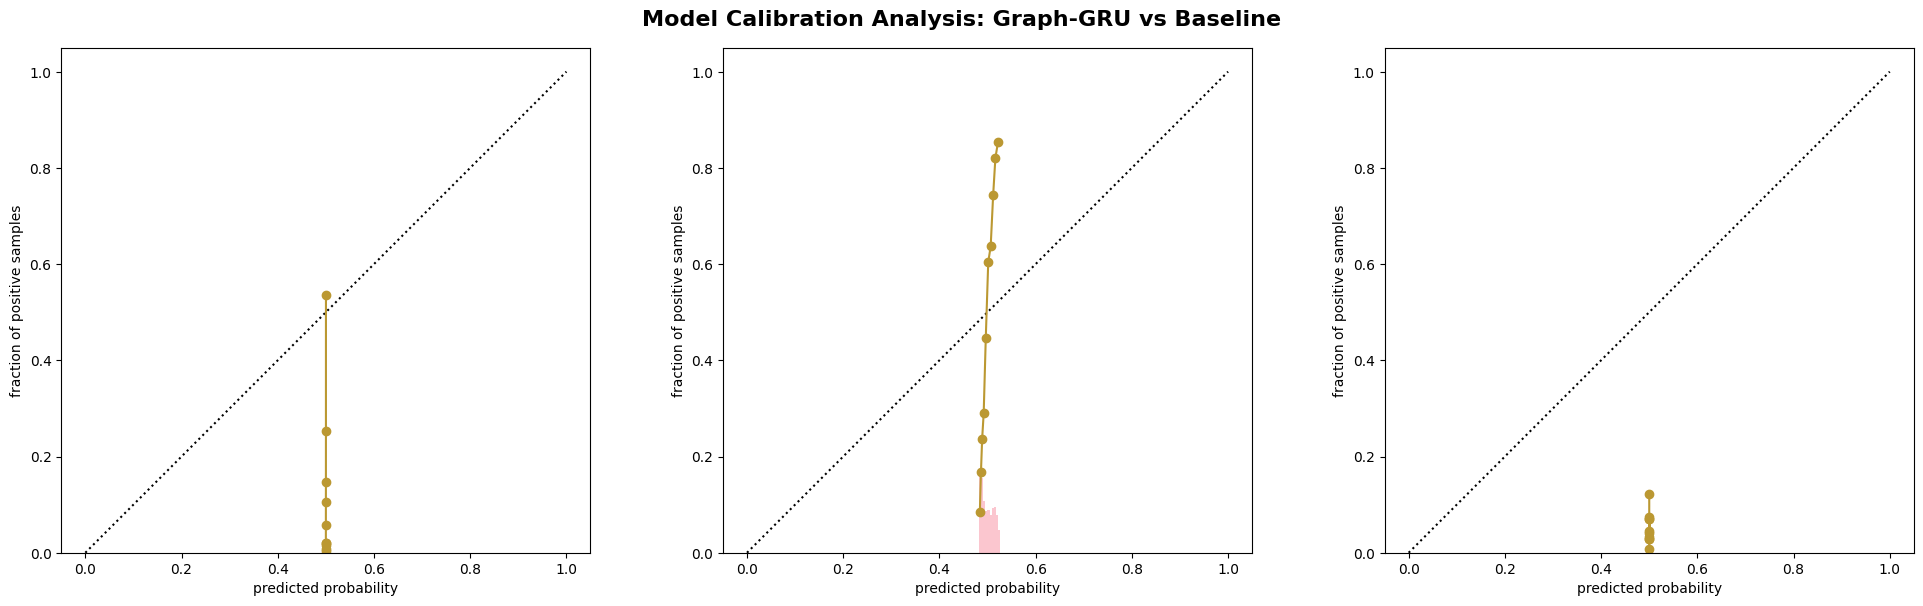

Calibration plots created successfully!


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create comprehensive calibration plots
print("Creating calibration plots...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Model Calibration Analysis: Graph-GRU vs Baseline', fontsize=16, fontweight='bold')

for i, task_name in enumerate(task_names):
    ax_model = axes[i]
    plot_calibration_curve(true_labels[task_name], model_predictions[task_name], 
                          ax=ax_model, n_bins=10)
plt.tight_layout()
plt.show()

print("Calibration plots created successfully!")


<!-- 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
Test Mortality: AUC-ROC: 0.85  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.82  AP: 0.80
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->

<!-- Test Mortality: AUC-ROC: 0.87  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.83  AP: 0.81
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->